In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from scipy import stats
import scorecardpy as sc
import warnings
warnings.filterwarnings("ignore")

Selamat Pagi/Siang/Malam kepada para pembaca laporan ini. dalam usecase ini, kami diberikan sebuah kasus untuk menilai apakah seorang pelanggan memiliki potensi untuk dinilai sebagai BAD credit atau tidak. oleh karena itu kami akan membuat model machine learning klasifikasi. karena dalam kasus ini menyangkut proses peminjaman uang dalam jumlah besar maka kami memilih precision sebagai tolak ukur yang utama.

Read Data

In [69]:
df = pd.read_csv('hmeq.csv')

In [70]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Data preparation

In [71]:
df.isnull().mean() * 100

BAD         0.000000
LOAN        0.000000
MORTDUE     8.691275
VALUE       1.879195
REASON      4.228188
JOB         4.681208
YOJ         8.640940
DEROG      11.879195
DELINQ      9.731544
CLAGE       5.167785
NINQ        8.557047
CLNO        3.724832
DEBTINC    21.258389
dtype: float64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [73]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [74]:
cat = ['REASON', 'JOB']
num = ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

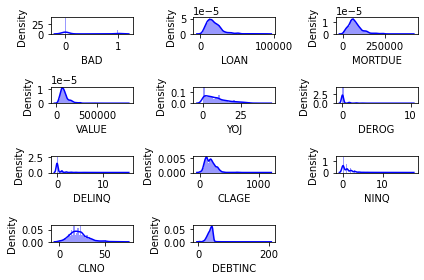

In [75]:
#plot distribusi sebelum missing value diisi
for i in range(0, len(num)):
  plt.subplot(4, len(num)/3, i+1)
  sns.distplot(df[num[i]], color="blue")
  plt.tight_layout()

In [76]:
# missing value = modus untuk kategori
df['REASON'] = df['REASON'].fillna(df['REASON'].mode()[0])
df['JOB'] = df['JOB'].fillna(df['JOB'].mode()[0])

In [77]:
# missing value < 5% dengan menggunkan mean atau media untuk float/int
df['VALUE'] = df['VALUE'].fillna(df['VALUE'].mean())
df['CLNO'] = df['CLNO'].fillna(df['CLNO'].mean())

In [78]:
#one hot encoding
cat=df.select_dtypes('object').columns.to_numpy() # ini adalah proses mengambil semua kolom data yang bersifat object dan mengubahnya menjadi one hot encoding

print(cat)

for i in cat:
    df = pd.get_dummies(df, columns=[i])

['REASON' 'JOB']


In [79]:
# untuk missing value diatas 5%, menggunakan mice imputation untuk mengisi missing value
from impyute.imputation.cs import mice

train_mice = mice(df.values)

In [80]:
df[df.columns] = train_mice
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1.0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,36.580813,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,37.791302,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,36.566454,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1500.0,76501.112207,101776.048741,6.642236,0.69889,1.212603,138.363147,1.902569,21.296096,38.744136,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,33.734633,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


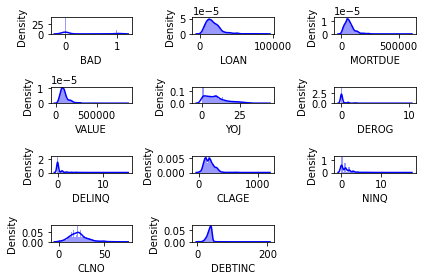

In [81]:
#plot distribusi setelah missing value diisi.
for i in range(0, len(num)):
  plt.subplot(4, len(num)/3, i+1)
  sns.distplot(df[num[i]], color="blue")
  plt.tight_layout()

In [82]:
# melihat apakah data sudah bersih atau belum
df.isnull().mean() * 100

BAD               0.0
LOAN              0.0
MORTDUE           0.0
VALUE             0.0
YOJ               0.0
DEROG             0.0
DELINQ            0.0
CLAGE             0.0
NINQ              0.0
CLNO              0.0
DEBTINC           0.0
REASON_DebtCon    0.0
REASON_HomeImp    0.0
JOB_Mgr           0.0
JOB_Office        0.0
JOB_Other         0.0
JOB_ProfExe       0.0
JOB_Sales         0.0
JOB_Self          0.0
dtype: float64

Data Outlier

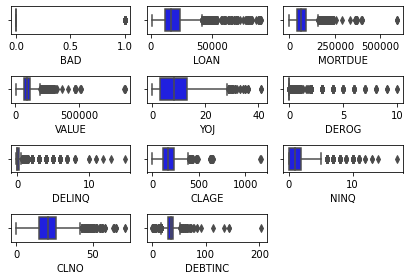

In [83]:
#kita akan melihat data apakah memiliki outlier
for i in range(0, len(num)):
  plt.subplot(4, len(num)/3, i+1)
  sns.boxplot(df[num[i]], color="blue", orient="h")
  plt.tight_layout()

In [84]:
q3=df['LOAN'].quantile(0.75)
q1=df['LOAN'].quantile(0.25)
IQR=q3-q1
df=df[(df['LOAN']>=q1-(1.5*IQR)) & 
       (df['LOAN']<=q3+(1.5*IQR))]

q3=df['MORTDUE'].quantile(0.75)
q1=df['MORTDUE'].quantile(0.25)
IQR=q3-q1
df=df[(df['MORTDUE']>=q1-(1.5*IQR)) & 
       (df['MORTDUE']<=q3+(1.5*IQR))]

q3=df['VALUE'].quantile(0.75)
q1=df['VALUE'].quantile(0.25)
IQR=q3-q1
df=df[(df['VALUE']>=q1-(1.5*IQR)) & 
       (df['VALUE']<=q3+(1.5*IQR))]

q3=df['YOJ'].quantile(0.75)
q1=df['YOJ'].quantile(0.25)
IQR=q3-q1
df=df[(df['YOJ']>=q1-(1.5*IQR)) & 
       (df['YOJ']<=q3+(1.5*IQR))]

q3=df['CLAGE'].quantile(0.75)
q1=df['CLAGE'].quantile(0.25)
IQR=q3-q1
df=df[(df['CLAGE']>=q1-(1.5*IQR)) & 
       (df['CLAGE']<=q3+(1.5*IQR))]

q3=df['NINQ'].quantile(0.75)
q1=df['NINQ'].quantile(0.25)
IQR=q3-q1
df=df[(df['NINQ']>=q1-(1.5*IQR)) & 
       (df['NINQ']<=q3+(1.5*IQR))]

q3=df['CLNO'].quantile(0.75)
q1=df['CLNO'].quantile(0.25)
IQR=q3-q1
df=df[(df['CLNO']>=q1-(1.5*IQR)) & 
       (df['CLNO']<=q3+(1.5*IQR))]

q3=df['DEBTINC'].quantile(0.75)
q1=df['DEBTINC'].quantile(0.25)
IQR=q3-q1
df=df[(df['DEBTINC']>=q1-(1.5*IQR)) & 
       (df['DEBTINC']<=q3+(1.5*IQR))]

p_derog = df['DEROG'].quantile([0.95]).values
nol = 0
df['DEROG'] = df['DEROG'].clip(nol,p_derog[0])

p_DELINQ = df['DELINQ'].quantile([0.79]).values
df['DELINQ'] = df['DELINQ'].clip(nol,p_DELINQ[0])


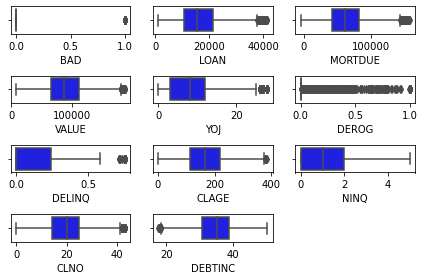

In [85]:
#setelah outlier dihapus
for i in range(0, len(num)):
  plt.subplot(4, len(num)/3, i+1)
  sns.boxplot(df[num[i]], color="blue", orient="h")
  plt.tight_layout()

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4777 entries, 0 to 5703
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAD             4777 non-null   float64
 1   LOAN            4777 non-null   float64
 2   MORTDUE         4777 non-null   float64
 3   VALUE           4777 non-null   float64
 4   YOJ             4777 non-null   float64
 5   DEROG           4777 non-null   float64
 6   DELINQ          4777 non-null   float64
 7   CLAGE           4777 non-null   float64
 8   NINQ            4777 non-null   float64
 9   CLNO            4777 non-null   float64
 10  DEBTINC         4777 non-null   float64
 11  REASON_DebtCon  4777 non-null   float64
 12  REASON_HomeImp  4777 non-null   float64
 13  JOB_Mgr         4777 non-null   float64
 14  JOB_Office      4777 non-null   float64
 15  JOB_Other       4777 non-null   float64
 16  JOB_ProfExe     4777 non-null   float64
 17  JOB_Sales       4777 non-null   f

EDA

In [87]:
df_eda = pd.read_csv('hmeq.csv')

Text(0.5, 1.0, 'Persentase Nasabah Sukses/Gagal Bayar Pinjaman')

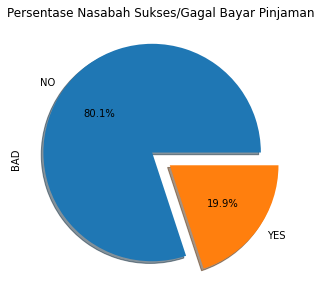

In [88]:
labels='NO','YES'
df_eda['BAD'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels, autopct='%1.1f%%',shadow=True, figsize=(5,5)).set_title('Persentase Nasabah Sukses/Gagal Bayar Pinjaman')

19.5% nasabah gagal bayar pinjaman dari total data yang sudah diberikan.

In [89]:
datas=df_eda[['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]
datas["BAD"].replace({0: "No", 1: "Yes"}, inplace=True)

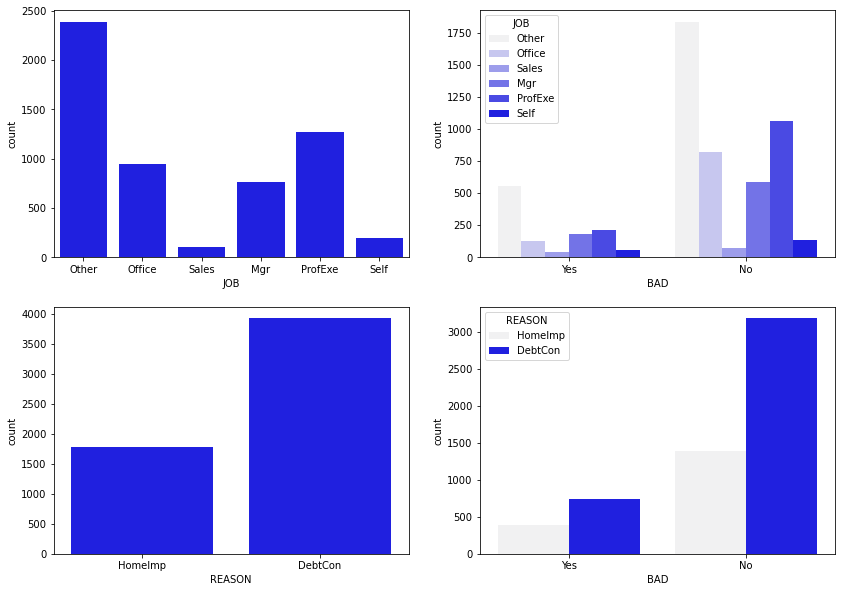

In [90]:
fig, ax=plt.subplots(nrows=2, ncols=2, figsize=(14,10))
sns.countplot('JOB', data=datas, color='blue',ax=ax[0,0])
sns.countplot('BAD',hue='JOB', data=datas, color='blue',ax=ax[0,1])
sns.countplot('REASON', data=datas, color='blue',ax=ax[1,0])
sns.countplot('BAD',hue='REASON', data=datas, color='blue',ax=ax[1,1])
plt.show()

*   Nasabah didominasi oleh berbagai profesi yang tidak ada dalam list(other) dan diikuti oleh profesi ProfExe, office, dan mgr. sehingga ketika mau meningkatkan jumlah peminjam, orang2 dengan profesi tersebut dapat dijadikan sebagai target
*   alasan yang digunakan nasabah kebanyakan adalah debtcon
*   nasabah yang gagal bayar didominasi oleh profesi other, namun hal tersebut sebanding dengan jumlah nasabahnya
*  nasabah dengan alasan debt lebih mampu membayar pinjaman daripada dengan alasan home improvement

Text(0.5, 1.0, 'Nominal Pinjaman Berdasarkan Profesi')

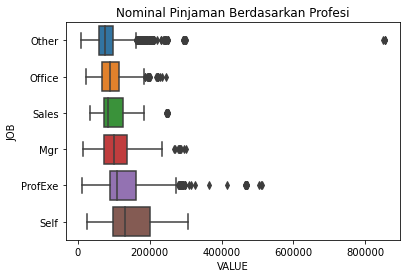

In [91]:
sns.boxplot(x='VALUE', y='JOB', data=datas).set_title('Nominal Pinjaman Berdasarkan Profesi')

nasabah dengan profesi self nominal pinjamannya rata2 lebih tinggi dari profesi lain.

(array([0, 1]), [Text(0, 0, 'Yes'), Text(1, 0, 'No')])

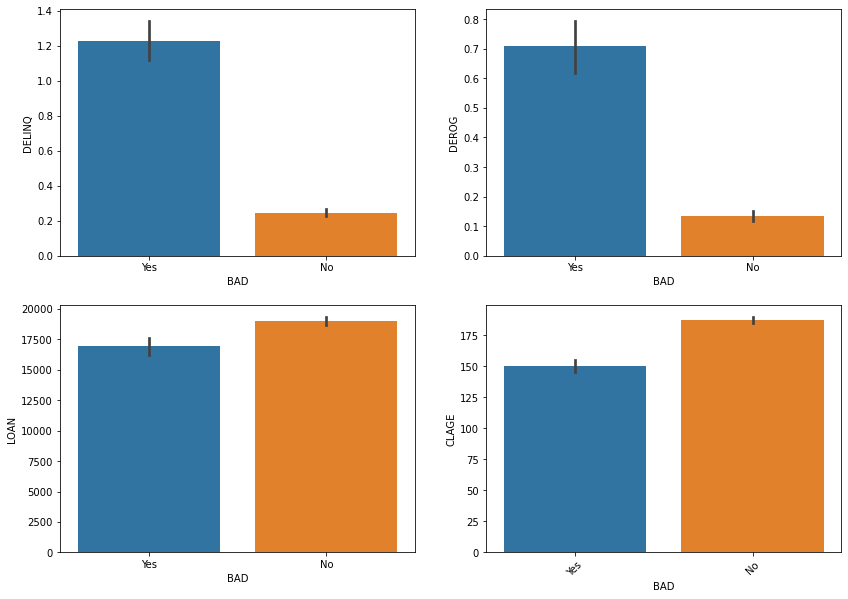

In [92]:
fig, ax=plt.subplots(nrows=2, ncols=2, figsize=(14,10))
sns.barplot(x='BAD', y='DELINQ', data=datas,ax=ax[0,0]);
sns.barplot(x='BAD', y='DEROG', data=datas,ax=ax[0,1]);
sns.barplot(x='BAD', y='LOAN', data=datas,ax=ax[1,0]);
sns.barplot(x='BAD', y='CLAGE', data=datas,ax=ax[1,1]);
plt.xticks(rotation=45)

*   Nasabah yang gagal bayar memiliki nilai DEROG ataupun DELINQ yanng lebih tinggi daripada yang suskses bayar
*   Nasabah yang gagal bayar memiliki nilai LOAN ataupun CLAGE yanng lebih rendah daripada yang suskses bayar. akan tetapi perbedaannnya tidak terlalu signifikan

<AxesSubplot:>

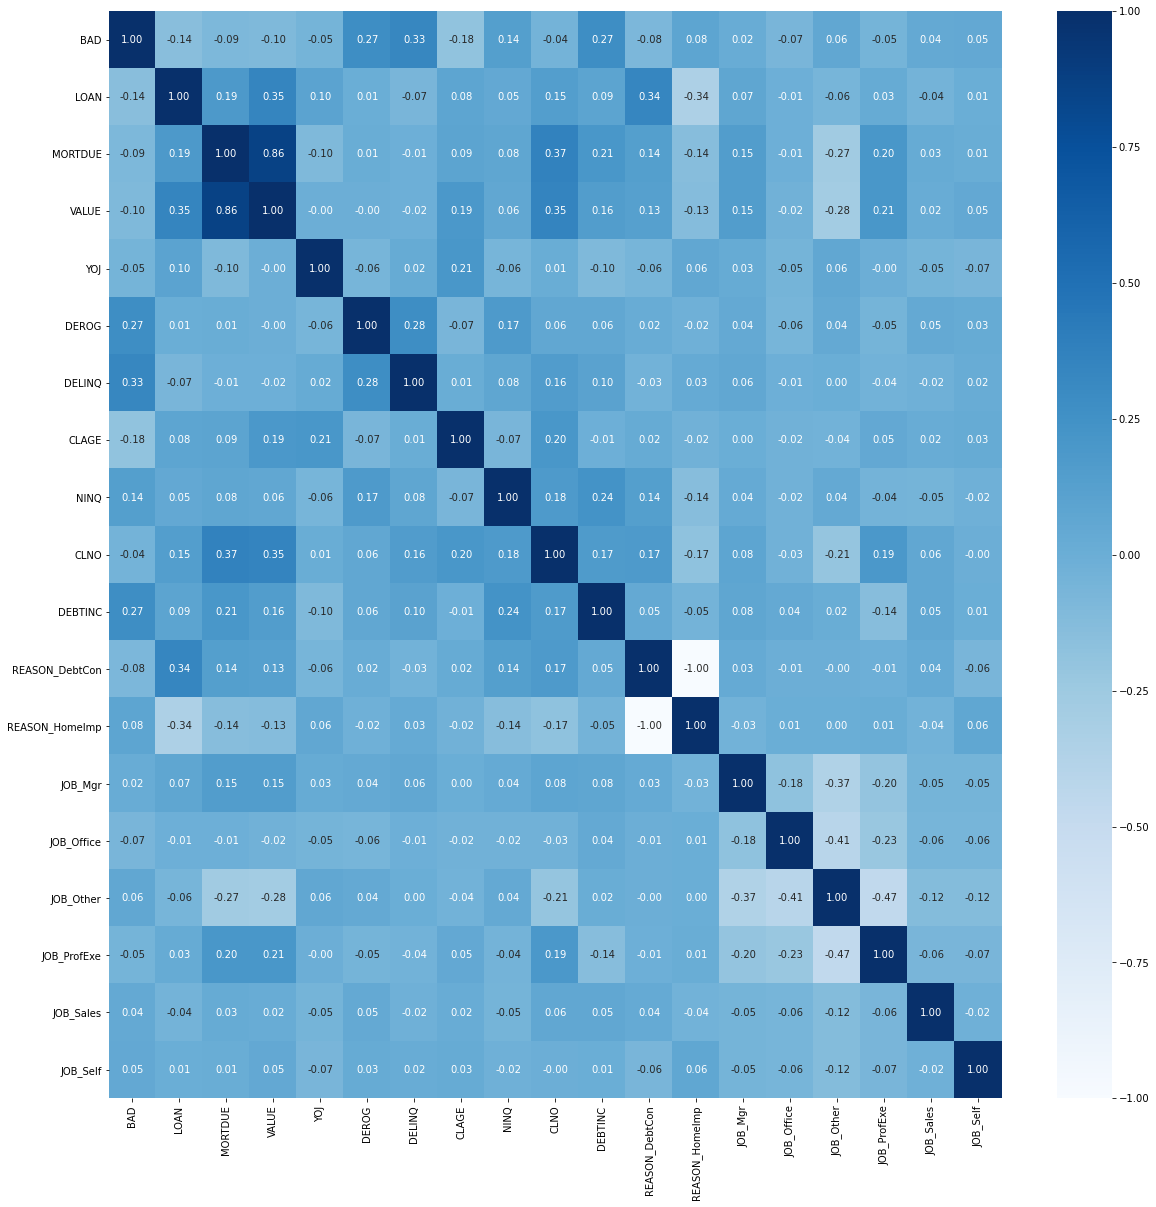

In [93]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap="Blues", annot=True, fmt=".2f")

korelasi antara target dengan prediktor <0.5 sehingga tidak ada yang bisa disebut sebagai prediktor yang tinggi

Feature Engineering

In [94]:
scaler = StandardScaler()
df['LOAN']= scaler.fit_transform(df['LOAN'].values.reshape(len(df),1))
df['MORTDUE'] = scaler.fit_transform(df['MORTDUE'].values.reshape(len(df),1))
df['VALUE'] = scaler.fit_transform(df['VALUE'].values.reshape(len(df),1))
df['YOJ'] = scaler.fit_transform(df['YOJ'].values.reshape(len(df),1))
df['CLAGE'] = scaler.fit_transform(df['CLAGE'].values.reshape(len(df),1))
df['CLNO'] = scaler.fit_transform(df['CLNO'].values.reshape(len(df),1))
df['DEBTINC'] = scaler.fit_transform(df['DEBTINC'].values.reshape(len(df),1))

In [95]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1.0,-2.053196,-1.215509,-1.435437,0.270682,0.00000,0.000000,-1.056218,1.000000,-1.342988,0.385805,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,-2.026138,0.217087,-0.626525,-0.246945,0.00000,0.754069,-0.679024,0.000000,-0.746131,0.594105,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,-1.999080,-1.616181,-2.050210,-0.690625,0.00000,0.000000,-0.299541,1.000000,-1.223617,0.383334,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,-1.999080,0.426114,0.292565,-0.299856,0.69889,0.754069,-0.452024,1.902569,0.124815,0.758069,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,-1.972022,1.116556,0.574106,-0.838519,0.00000,0.000000,-1.070408,0.000000,-0.746131,-0.103965,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Split train test dataset

In [96]:
dataset_x = df.drop(labels='BAD', axis=1)
dataset_x.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-2.053196,-1.215509,-1.435437,0.270682,0.00000,0.000000,-1.056218,1.000000,-1.342988,0.385805,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-2.026138,0.217087,-0.626525,-0.246945,0.00000,0.754069,-0.679024,0.000000,-0.746131,0.594105,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.999080,-1.616181,-2.050210,-0.690625,0.00000,0.000000,-0.299541,1.000000,-1.223617,0.383334,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.999080,0.426114,0.292565,-0.299856,0.69889,0.754069,-0.452024,1.902569,0.124815,0.758069,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.972022,1.116556,0.574106,-0.838519,0.00000,0.000000,-1.070408,0.000000,-0.746131,-0.103965,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [97]:
dataset_y = df['BAD']
dataset_y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: BAD, dtype: float64

In [98]:
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, train_size=0.8, random_state=0)

In [99]:
from imblearn import over_sampling # disini kita akan melakukan oversampling
X_train, y_train = over_sampling.RandomOverSampler().fit_resample(X_train, y_train)

In [100]:
X_test, y_test = over_sampling.RandomOverSampler().fit_resample(X_test, y_test)

In [101]:
y_train.value_counts(), len(X_train)

(0.0    3105
 1.0    3105
 Name: BAD, dtype: int64,
 6210)

Feature selection

In [102]:
def get_IV(df, feature, target):
    lst = []
    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append([feature,                                                        
                    val,                                                            
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]   
                   ])
 
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

        
    total_bad = df[df[target] == 0].count()[feature]
    total_good = df.shape[0] - total_bad
    
    data['Distribution Good'] = data['Good']/ total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    iv = data['IV'].sum()

    return iv, data

In [103]:
%%time

x=df.columns.to_numpy()
ivarr=[]
ivcol=[]

for i in x:
    iv,data = get_IV(df, i, 'BAD')
    ivarr.append(iv)
    ivcol.append(i)

Wall time: 41.4 s


In [104]:
i_values = pd.DataFrame({'column':ivcol,'information_value':ivarr})

In [105]:
display(i_values)

,column,information_value
0,BAD,0.000000
1,LOAN,0.756672
2,MORTDUE,0.315684
3,VALUE,0.703413
4,YOJ,0.238541
5,DEROG,0.287200
6,DELINQ,0.609908
7,CLAGE,0.149671
8,NINQ,0.095913
9,CLNO,0.236491


In [106]:
setelah= i_values['information_value']>=0.1
sebelum = i_values['information_value']<=1
i_value= i_values.loc[setelah & sebelum]
i_value = i_value.sort_values(by=['information_value'],ascending=False)

In [107]:
display(i_value)

,column,information_value
1,LOAN,0.756672
3,VALUE,0.703413
6,DELINQ,0.609908
2,MORTDUE,0.315684
5,DEROG,0.287200
4,YOJ,0.238541
9,CLNO,0.236491
7,CLAGE,0.149671


In [108]:
fitur = i_value['column'].to_numpy()
fitur = i_value['column'].to_numpy()
X_train = X_train[fitur]

X_test= X_test[fitur]

Machine Learning Model

              precision    recall  f1-score   support

         0.0       0.80      0.68      0.74       757
         1.0       0.72      0.83      0.77       757

    accuracy                           0.75      1514
   macro avg       0.76      0.75      0.75      1514
weighted avg       0.76      0.75      0.75      1514



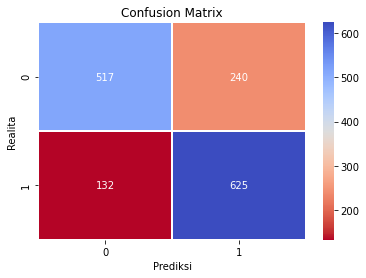

In [133]:
#logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred1 = (lr.predict_proba(X_test)[:,1] >= 0.45).astype(bool)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred1)
print (metrics.classification_report(y_test,y_pred1))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

ROCAUC: 0.7542932628797887


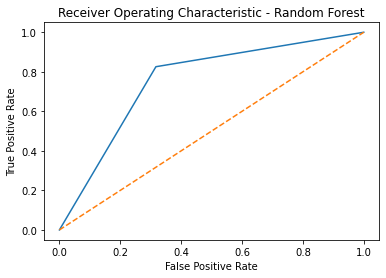

In [110]:
print("ROCAUC:",roc_auc_score(y_test, y_pred1))

y_score = (lr.predict_proba(X_test)[:,1] >= 0.45).astype(bool)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_RF.png',dpi=100)
plt.show()

              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82       757
         1.0       0.91      0.65      0.76       757

    accuracy                           0.79      1514
   macro avg       0.82      0.79      0.79      1514
weighted avg       0.82      0.79      0.79      1514



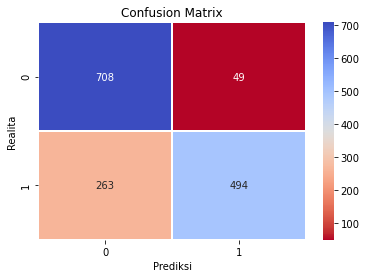

In [111]:
#decision tree
from sklearn import tree

tree = tree.DecisionTreeClassifier()

tree.fit(X_train, y_train)

y_pred2 = tree.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred2)
print (metrics.classification_report(y_test,y_pred2))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

ROCAUC: 0.7939233817701452


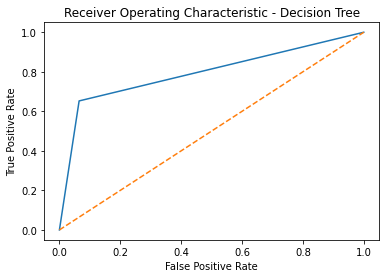

In [112]:
print("ROCAUC:",roc_auc_score(y_test, y_pred2))

y_score = tree.predict(X_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       757
         1.0       0.89      0.95      0.92       757

    accuracy                           0.91      1514
   macro avg       0.92      0.91      0.91      1514
weighted avg       0.92      0.91      0.91      1514



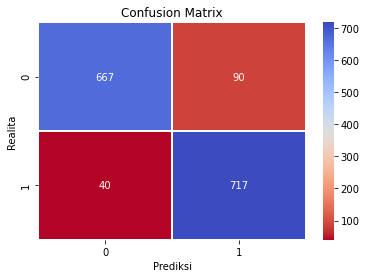

In [113]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)

rf.fit(X_train,y_train)

y_pred3= (rf.predict_proba(X_test)[:,1] >= 0.25).astype(bool)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred3)
print (metrics.classification_report(y_test,y_pred3))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

ROCAUC: 0.9141347424042272


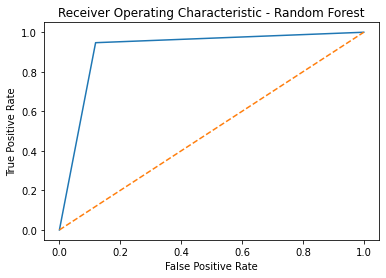

In [114]:
print("ROCAUC:",roc_auc_score(y_test, y_pred3))

y_score = (rf.predict_proba(X_test)[:,1] >= 0.25).astype(bool)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_RF.png',dpi=100)
plt.show()

[21:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       757
         1.0       0.91      0.85      0.88       757

    accuracy                           0.88      1514
   macro avg       0.88      0.88      0.88      1514
weighted avg       0.88      0.88      0.88      1514



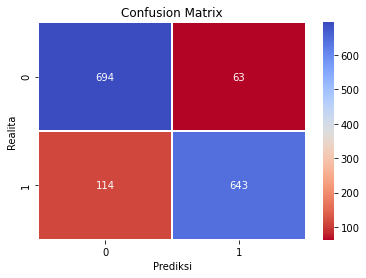

In [115]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train , y_train)

y_pred5 = (xgb.predict_proba(X_test)[:,1] >= 0.25).astype(bool)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred5)
print (metrics.classification_report(y_test,y_pred5))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

ROCAUC: 0.8830911492734477


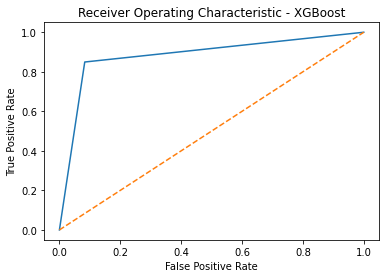

In [116]:
print("ROCAUC:",roc_auc_score(y_test, y_pred5))

y_score = (xgb.predict_proba(X_test)[:,1] >= 0.25).astype(bool)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_RF.png',dpi=100)
plt.show()

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       757
         1.0       0.95      0.92      0.94       757

    accuracy                           0.94      1514
   macro avg       0.94      0.94      0.94      1514
weighted avg       0.94      0.94      0.94      1514



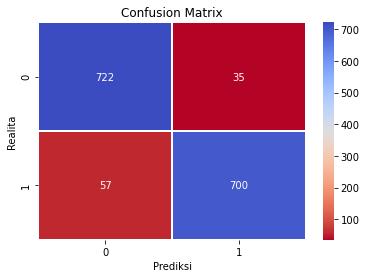

In [117]:
from sklearn.ensemble import ExtraTreesClassifier

xt = ExtraTreesClassifier()

xt.fit(X_train , y_train)

y_pred7 = (xt.predict_proba(X_test)[:,1] >= 0.25).astype(bool)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred7)
print (metrics.classification_report(y_test,y_pred7))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

ROCAUC: 0.9392338177014531


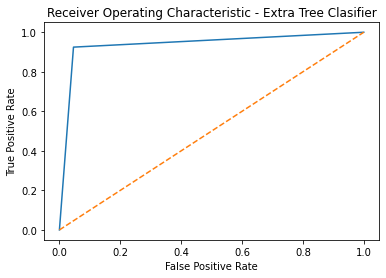

In [118]:
print("ROCAUC:",roc_auc_score(y_test, y_pred7))

y_score = (xt.predict_proba(X_test)[:,1] >= 0.25).astype(bool)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Extra Tree Clasifier')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_RF.png',dpi=100)
plt.show()

Threshold Tuning

In [119]:
def threshold(classifier):
    acc=[]
    rec=[]
    prec=[]
    roc_auc=[]
    f1=[]
    threshold=[i/20 for i in range(1,20)]
    for i in threshold:
        preds = np.where(classifier.predict_proba(X_test)[:,1] >= i, 1, 0)
        acc.append(metrics.accuracy_score(y_test, preds))
        rec.append(metrics.recall_score(y_test, preds))
        prec.append(metrics.precision_score(y_test, preds,zero_division=1))
        roc_auc.append(metrics.roc_auc_score(y_test, preds))
        f1.append(metrics.f1_score(y_test, preds))
    threshold = pd.DataFrame({'Threshold':threshold,'Accuracy':acc,'Precision':prec,'recall':rec,'roc_auc':roc_auc,'f1_score':f1})
    display(threshold)

In [120]:
threshold(lr)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.500000,0.500000,1.000000,0.500000,0.666667
1,0.10,0.515192,0.507713,1.000000,0.515192,0.673488
2,0.15,0.547556,0.524965,1.000000,0.547556,0.688495
3,0.20,0.591810,0.550767,0.996037,0.591810,0.709313
4,0.25,0.643329,0.584567,0.990753,0.643329,0.735294
5,0.30,0.687583,0.619529,0.972259,0.687583,0.756812
6,0.35,0.703435,0.640000,0.929987,0.703435,0.758212
7,0.40,0.729855,0.676829,0.879789,0.729855,0.765078
8,0.45,0.754293,0.722543,0.825627,0.754293,0.770654
9,0.50,0.741083,0.739187,0.745046,0.741083,0.742105


In [121]:
threshold(tree)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.793923,0.909761,0.652576,0.793923,0.76
1,0.10,0.793923,0.909761,0.652576,0.793923,0.76
2,0.15,0.793923,0.909761,0.652576,0.793923,0.76
3,0.20,0.793923,0.909761,0.652576,0.793923,0.76
4,0.25,0.793923,0.909761,0.652576,0.793923,0.76
5,0.30,0.793923,0.909761,0.652576,0.793923,0.76
6,0.35,0.793923,0.909761,0.652576,0.793923,0.76
7,0.40,0.793923,0.909761,0.652576,0.793923,0.76
8,0.45,0.793923,0.909761,0.652576,0.793923,0.76
9,0.50,0.793923,0.909761,0.652576,0.793923,0.76


In [122]:
threshold(rf)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.712021,0.636132,0.990753,0.712021,0.774793
1,0.10,0.821004,0.742515,0.982827,0.821004,0.845935
2,0.15,0.875826,0.817168,0.968296,0.875826,0.886336
3,0.20,0.903567,0.861538,0.961691,0.903567,0.908864
4,0.25,0.914135,0.888476,0.947160,0.914135,0.916880
5,0.30,0.920079,0.917323,0.923382,0.920079,0.920342
6,0.35,0.914795,0.933702,0.892999,0.914795,0.912897
7,0.40,0.900264,0.946903,0.848085,0.900264,0.894774
8,0.45,0.877807,0.956869,0.791281,0.877807,0.866233
9,0.50,0.857992,0.968858,0.739762,0.857992,0.838951


In [123]:
threshold(xgb)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.829590,0.769148,0.941876,0.829590,0.846793
1,0.10,0.877807,0.842926,0.928666,0.877807,0.883721
2,0.15,0.885073,0.881046,0.890357,0.885073,0.885677
3,0.20,0.887054,0.895946,0.875826,0.887054,0.885772
4,0.25,0.883091,0.910765,0.849406,0.883091,0.879016
5,0.30,0.884412,0.922965,0.838838,0.884412,0.878893
6,0.35,0.889036,0.938897,0.832232,0.889036,0.882353
7,0.40,0.877147,0.944012,0.801849,0.877147,0.867143
8,0.45,0.870542,0.954619,0.778071,0.870542,0.857351
9,0.50,0.856011,0.962264,0.741083,0.856011,0.837313


In [124]:
threshold(xt)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.782034,0.696412,1.000000,0.782034,0.821041
1,0.10,0.883091,0.819383,0.982827,0.883091,0.893694
2,0.15,0.924703,0.890644,0.968296,0.924703,0.927848
3,0.20,0.937252,0.928756,0.947160,0.937252,0.937868
4,0.25,0.939234,0.952381,0.924703,0.939234,0.938338
5,0.30,0.933289,0.965909,0.898283,0.933289,0.930869
6,0.35,0.921400,0.974702,0.865258,0.921400,0.916725
7,0.40,0.898283,0.980861,0.812417,0.898283,0.888728
8,0.45,0.859974,0.982301,0.733157,0.859974,0.839637
9,0.50,0.828269,0.984405,0.667107,0.828269,0.795276


Cross Validation

In [125]:
from sklearn.model_selection import cross_validate as cvs
def crossval(model):
    cvscore = cvs(estimator=model,X=X_train,y=y_train,cv=10,scoring=['accuracy','precision','recall','f1','average_precision','roc_auc'])
    score_table=pd.DataFrame(cvscore)
    score_table.index+=1
    display(score_table)

In [126]:
crossval(lr)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.020945,0.007005,0.710145,0.716667,0.693548,0.704918,0.792309,0.775542
2,0.014901,0.009007,0.682770,0.695502,0.648387,0.671119,0.759386,0.757536
3,0.015564,0.007010,0.711755,0.729825,0.670968,0.699160,0.785357,0.778498
4,0.014349,0.007007,0.726248,0.736486,0.703226,0.719472,0.808164,0.801877
5,0.015247,0.005986,0.687601,0.698630,0.658065,0.677741,0.754854,0.753708
6,0.013871,0.007010,0.698873,0.740310,0.614148,0.671353,0.796545,0.774100
7,0.016237,0.006985,0.711755,0.734043,0.665595,0.698145,0.768926,0.778280
8,0.014104,0.006002,0.732689,0.752613,0.694534,0.722408,0.820247,0.806431
9,0.013953,0.007008,0.698873,0.718310,0.655949,0.685714,0.790782,0.774474
10,0.015655,0.006985,0.763285,0.775168,0.742765,0.758621,0.828137,0.821409


In [127]:
crossval(tree)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.028952,0.007979,0.962963,0.936170,0.993548,0.964006,0.933351,0.963012
2,0.029919,0.008946,0.977456,0.959627,0.996774,0.977848,0.958142,0.977487
3,0.026930,0.009000,0.972625,0.948012,1.000000,0.973312,0.948012,0.972669
4,0.024925,0.010002,0.961353,0.928144,1.000000,0.962733,0.928144,0.961415
5,0.024904,0.008008,0.969404,0.942249,1.000000,0.970266,0.942249,0.969453
6,0.022909,0.009007,0.972625,0.948171,1.000000,0.973396,0.948171,0.972581
7,0.022908,0.007010,0.982287,0.965839,1.000000,0.982622,0.965839,0.982258
8,0.021941,0.006979,0.966184,0.936747,1.000000,0.967341,0.936747,0.966129
9,0.021941,0.010972,0.974235,0.951070,1.000000,0.974922,0.951070,0.974194
10,0.022936,0.006982,0.972625,0.948171,1.000000,0.973396,0.948171,0.972581


In [128]:
crossval(rf)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.577963,0.043911,0.991948,0.987220,0.996774,0.991974,0.998639,0.997874
2,0.584377,0.047872,0.985507,0.974763,0.996774,0.985646,0.999739,0.999730
3,0.574462,0.044884,0.993559,0.987261,1.000000,0.993590,0.999959,0.999959
4,0.552955,0.045877,0.982287,0.965732,1.000000,0.982567,0.999917,0.999917
5,0.549529,0.042886,0.991948,0.984127,1.000000,0.992000,1.000000,1.000000
6,0.582474,0.046904,0.988728,0.977987,1.000000,0.988871,0.999939,0.999943
7,0.551016,0.042886,0.993559,0.987302,1.000000,0.993610,1.000000,1.000000
8,0.554594,0.043883,0.977456,0.956923,1.000000,0.977987,0.999697,0.999710
9,0.574563,0.043880,0.979066,0.959877,1.000000,0.979528,1.000000,1.000000
10,0.562894,0.042886,0.991948,0.984177,1.000000,0.992026,0.999748,0.999751


In [129]:
crossval(xgb)

[21:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.309171,0.011968,0.974235,0.956522,0.993548,0.974684,0.995627,0.995602
2,0.288229,0.010971,0.975845,0.959502,0.993548,0.976228,0.997259,0.997438
3,0.289226,0.011968,0.983897,0.977707,0.990323,0.983974,0.998464,0.998569
4,0.291220,0.011969,0.975845,0.953846,1.000000,0.976378,0.994653,0.996401
5,0.290223,0.011968,0.988728,0.980952,0.996774,0.988800,0.999325,0.999347
6,0.290223,0.010971,0.980676,0.962848,1.000000,0.981073,0.992895,0.995768
7,0.292217,0.010971,0.980676,0.962848,1.000000,0.981073,0.997213,0.997438
8,0.287231,0.011968,0.967794,0.944954,0.993569,0.968652,0.995863,0.996401
9,0.316626,0.012965,0.979066,0.959877,1.000000,0.979528,0.998651,0.998714
10,0.315597,0.012985,0.993559,0.990415,0.996785,0.993590,0.999857,0.999855


In [131]:
crossval(xt)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.315184,0.049988,0.991948,0.987220,0.996774,0.991974,0.999340,0.999238
2,0.312348,0.054825,0.993559,0.990385,0.996774,0.993569,0.999869,0.999865
3,0.314189,0.053866,0.995169,0.990415,1.000000,0.995185,0.999969,0.999984
4,0.330955,0.051862,0.995169,0.990415,1.000000,0.995185,1.000000,1.000000
5,0.328653,0.052859,0.996779,0.993590,1.000000,0.996785,1.000000,1.000000
6,0.328110,0.052855,0.998390,0.996795,1.000000,0.998395,1.000000,1.000000
7,0.330116,0.050895,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.321167,0.050454,0.990338,0.981073,1.000000,0.990446,1.000000,1.000000
9,0.314099,0.048869,0.995169,0.990446,1.000000,0.995200,1.000000,1.000000
10,0.309232,0.048933,0.993559,0.987302,1.000000,0.993610,1.000000,1.000000


Conclusion

dari kasus yang ditemui, kita memerlukan nilai precision yang memadai untuk bisa mengfilter pelanggan yang terindikasi BAD credit. dari 5 model yang dilakukan dan setelah melakukan threshold tuning, kami mendapati kalau model extra tree classifier yang memberikan nilai hasil yang bagus dengan nilai akurasi, precision, recall dan f1 score yang stabil dengan score 0.95.